# Goal : Image Captioning
> Image captioning is the task of generating natural language utterances based on the understanding of visual snippets of a scene. 


> A combination of Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs) which seeks to progress directly from image features to text can be progressed to define a single end-to-end model to maximize the likelihood of the target description sentence, given an image.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import os
import numpy as np
import pandas as pd
import string
import nltk

import matplotlib.pyplot as plt

from os import listdir
from pickle import dump
from pickle import load

import keras.backend as K

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, concatenate
from keras.layers import Flatten, Dense, Input, Activation, BatchNormalization,Conv2D,MaxPooling2D,Dropout
from keras.layers import Input, LSTM, GRU, Dense, Embedding, TimeDistributed,RepeatVector

from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras import regularizers

from nltk.tokenize import sent_tokenize, word_tokenize

# import imgaug as ia
# from imgaug import augmenters as iaa

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
BATCH_SIZE = 8  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.
LATENT_DIM = 1024  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

### About Dataset :
The Dataset we use is Flickr8k.
The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations.

The Dataset can be downloaded from : http://academictorrents.com/details/9dea07ba660a722ae1008c4c8afdd303b6f6e53b

It can also be downloaded by submitting a request on : https://forms.illinois.edu/sec/1713398 (This official site seems to have been taken down)


> **Flickr8k_Dataset:** Contains a total of 8092 images in JPEG format with different shapes and sizes. Of which
* 6000 are used for training
* 1000 for development
* 1000 for test  


> **Flickr8k_text :** Contains text files describing train_set ,test_set. Flickr8k.token.txt contains 5 captions for each image i.e. total 40460 captions.







In [6]:
"""
To read the file data

Arguments :
directory -- path of the directory

Returns :
text -- a variable with data stored in it 

"""

def load_data(directory):
    file=open(directory,'r')
    text=file.read()
    file.close()
    return text
		
"""
To create a list of dataset identifiers

Arguments :
directory -- path of the directory

Returns :
list(set(dataset)) -- The set form removes any duplicates in the dataset list provided and returns a list of identifiers
"""

def load_dataset(directory):
	doc=load_data(directory)
	dataset = list()
	for line in doc.split('\n'):
		if(len(line)<1):
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return list(set(dataset))

In [7]:
##let us load the train dataset now
train_file = 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train= load_dataset(train_file)
print('Dataset: %d' % len(train))

Dataset: 6000


In [8]:
##let us load the valid dataset now
valid_file = 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
valid= load_dataset(valid_file)
print('Dataset: %d' % len(valid))

Dataset: 1000


In [9]:
"""
Creates 2 dictionaries each with list of captions for an identifier ( 5 captions per identifier )

Arguments :
filename -- path to cleaned and preprocessed captions text file
dataset -- Dataset of identifiers 

Returns :
targets -- It is the true output with an <eos> appended to each caption to mark the end of sentence.

target_inputs -- Used for Teacher Forcing.
                 <sos> is appended at the beginning to produce an offset of 1 and as a start token.
"""
def load_all_description(filename,dataset):
  #sentence in target language 
  targets=dict()
  #sentence in target language offset by 1 
  target_inputs=dict()
  
  for line in open(filename):
    tokens=line.split()
    image_id,image_desc=tokens[0], tokens[1:]
    translation=" ".join(image_desc)
    if image_id in dataset:
      if image_id not in targets:
        targets[image_id] = list()
      if image_id not in target_inputs:
        target_inputs[image_id] = list()
      target_text = translation + ' <eos>'
      target_text_input = '<sos> ' + translation
      targets[image_id].append(target_text)
      target_inputs[image_id].append(target_text_input)

  return targets,target_inputs

In [10]:
target_texts,target_texts_inputs = load_all_description('gdrive/My Drive/Image_Captioning/descriptions.txt',train)
print ("The samples in target texts is : ", len(target_texts))
print ("The samples in target texts is : ", len(target_texts_inputs))
print(target_texts.get('1000268201_693b08cb0e'))
print(target_texts_inputs.get('1000268201_693b08cb0e'))

The samples in target texts is :  6000
The samples in target texts is :  6000
['child in pink dress is climbing up set of stairs in an entry way <eos>', 'girl going into wooden building <eos>', 'little girl climbing into wooden playhouse <eos>', 'little girl climbing the stairs to her playhouse <eos>', 'little girl in pink dress going into wooden cabin <eos>']
['<sos> child in pink dress is climbing up set of stairs in an entry way', '<sos> girl going into wooden building', '<sos> little girl climbing into wooden playhouse', '<sos> little girl climbing the stairs to her playhouse', '<sos> little girl in pink dress going into wooden cabin']


In [11]:
valid_texts,valid_texts_inputs = load_all_description('gdrive/My Drive/Image_Captioning/descriptions.txt',valid)
print ("The samples in target texts is : ", len(valid_texts))
print ("The samples in target texts is : ", len(valid_texts_inputs))
print(valid_texts.get('3523819210_99782628fc'))
print(valid_texts_inputs.get('3523819210_99782628fc'))

The samples in target texts is :  1000
The samples in target texts is :  1000
['man sits behind two cardboard canvasses <eos>', 'man sitting in blue metal chair <eos>', 'man sitting on chair on the street next to board <eos>', 'man is sitting in blue chair outside near large paintings <eos>', 'man is sitting in blue chair next two pieces of wood <eos>']
['<sos> man sits behind two cardboard canvasses', '<sos> man sitting in blue metal chair', '<sos> man sitting on chair on the street next to board', '<sos> man is sitting in blue chair outside near large paintings', '<sos> man is sitting in blue chair next two pieces of wood']


In [12]:
"""

Arguments : 
descriptions -- dictionary with a <identifier,list of 5 captions> as <key,value> pair

Returns :
all_desc -- list of all the captions 

"""
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

"""

Arguments : 
num_words -- Maximum number of words to work with
desc1, desc2 -- dictionaries on which the vocabulary is to be built

Returns : 
tokenizer

"""
 
# fit a tokenizer given caption descriptions
def create_tokenizer(num_words,desc1,desc2):
  targets = to_lines(desc1)
  target_inputs= to_lines(desc2)
  tokenizer = Tokenizer(num_words, filters='')
  tokenizer.fit_on_texts(targets + target_inputs)
  return tokenizer

In [13]:
tokenizer_outputs=create_tokenizer(MAX_NUM_WORDS,target_texts,target_texts_inputs)
print ("The length of the tokenizer dictionary is : ", len(tokenizer_outputs.word_index)+1)

word2idx_outputs = tokenizer_outputs.word_index
idx2word_trans = dict(map(reversed, word2idx_outputs.items()))

num_words_output = len(word2idx_outputs) + 1

The length of the tokenizer dictionary is :  7268


In [14]:
print (word2idx_outputs)

{'<eos>': 1, '<sos>': 2, 'in': 3, 'the': 4, 'on': 5, 'is': 6, 'and': 7, 'dog': 8, 'with': 9, 'man': 10, 'of': 11, 'two': 12, 'white': 13, 'black': 14, 'boy': 15, 'are': 16, 'woman': 17, 'girl': 18, 'to': 19, 'wearing': 20, 'at': 21, 'people': 22, 'water': 23, 'brown': 24, 'young': 25, 'red': 26, 'an': 27, 'his': 28, 'blue': 29, 'dogs': 30, 'running': 31, 'through': 32, 'playing': 33, 'while': 34, 'down': 35, 'shirt': 36, 'ball': 37, 'standing': 38, 'little': 39, 'grass': 40, 'snow': 41, 'child': 42, 'person': 43, 'jumping': 44, 'over': 45, 'three': 46, 'sitting': 47, 'front': 48, 'field': 49, 'holding': 50, 'small': 51, 'yellow': 52, 'green': 53, 'group': 54, 'up': 55, 'by': 56, 'large': 57, 'one': 58, 'walking': 59, 'her': 60, 'men': 61, 'children': 62, 'air': 63, 'into': 64, 'near': 65, 'mouth': 66, 'beach': 67, 'jumps': 68, 'runs': 69, 'another': 70, 'for': 71, 'street': 72, 'from': 73, 'its': 74, 'riding': 75, 'stands': 76, 'bike': 77, 'girls': 78, 'as': 79, 'outside': 80, 'play': 

In [15]:
print(idx2word_trans)

{1: '<eos>', 2: '<sos>', 3: 'in', 4: 'the', 5: 'on', 6: 'is', 7: 'and', 8: 'dog', 9: 'with', 10: 'man', 11: 'of', 12: 'two', 13: 'white', 14: 'black', 15: 'boy', 16: 'are', 17: 'woman', 18: 'girl', 19: 'to', 20: 'wearing', 21: 'at', 22: 'people', 23: 'water', 24: 'brown', 25: 'young', 26: 'red', 27: 'an', 28: 'his', 29: 'blue', 30: 'dogs', 31: 'running', 32: 'through', 33: 'playing', 34: 'while', 35: 'down', 36: 'shirt', 37: 'ball', 38: 'standing', 39: 'little', 40: 'grass', 41: 'snow', 42: 'child', 43: 'person', 44: 'jumping', 45: 'over', 46: 'three', 47: 'sitting', 48: 'front', 49: 'field', 50: 'holding', 51: 'small', 52: 'yellow', 53: 'green', 54: 'group', 55: 'up', 56: 'by', 57: 'large', 58: 'one', 59: 'walking', 60: 'her', 61: 'men', 62: 'children', 63: 'air', 64: 'into', 65: 'near', 66: 'mouth', 67: 'beach', 68: 'jumps', 69: 'runs', 70: 'another', 71: 'for', 72: 'street', 73: 'from', 74: 'its', 75: 'riding', 76: 'stands', 77: 'bike', 78: 'girls', 79: 'as', 80: 'outside', 81: 'pla

In [16]:
"""
Finds the maximum length of the caption.

Arguments : 
desc1 -- dictionary with a <identifier,list of 5 captions> as <key,value> pair

Returns :
max(length) -- maximum length of the caption in the given dataset
"""

def max_length(desc1):
  length=[]
  targets = to_lines(desc1)
  for sentence in targets:
    length.append(len(word_tokenize(sentence)))
  return max(length)

In [17]:
max_len_target=max_length(target_texts)
print ("The maximum length in target sequences is :",max_len_target)

The maximum length in target sequences is : 34


In [18]:
# image_orginial = get_image_representation(test_paths,channel_orientation = "channels_last")
# image_orginial.shape

In [19]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image

In [ ]:
# image_orginial = preprocess(test_paths,channel_orientation = "channels_last")

In [ ]:
# image_orginial.shape

In [ ]:
# test_path="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3251460982_4578a568bb.jpg"
# preprocess(test_path).shape

In [ ]:
# target_texts.get("709373049_15b8b6457a")

In [ ]:
# batch_test=train[2:7]
# test_paths=[]
# test_decoder_input=[]
# test_decoder_target=[]

# visual_filename='gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset'
# for img_id in batch_test:
#   for i in range(5):
#     test_paths.append(visual_filename+ '/' + img_id +'.jpg')
#   list1=target_texts_inputs.get(img_id)
#   list2=target_texts.get(img_id)
#   for m in list1:
#     test_decoder_input.append(m)
#   for n in list2:
#     test_decoder_target.append(n)


In [ ]:
# test_paths

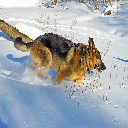

In [ ]:
test_img = load_img("gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3251460982_4578a568bb.jpg", target_size=(128, 128))
test_img

In [ ]:
# test_decoder_input

In [ ]:
# get_image_representation(test_paths).shape

In [ ]:
batch_test=train[2:7]
extracted_features=np.zeros((25,1,2048))
n_caps=5
for i in range(len(batch_test)):
  img_id=batch_test[i]
  for m in range(5):
    extracted_features[(n_caps*i)+m]=encoding_train.get(img_id+".jpg")

In [ ]:
extracted_features.shape

(25, 1, 2048)

In [20]:
import pickle
encoding_train = pickle.load(open('gdrive/My Drive/Image_Captioning/encoded_images_inceptionV3.p', 'rb'))
encoding_val = pickle.load(open('gdrive/My Drive/Image_Captioning/encoded_images_val_inceptionV3.p', 'rb'))

In [21]:

"""
Generates batches of data for Model

"""

"""
visual_filename
train
n_caps
"""
def load_batches(target_texts,target_texts_inputs,train,visual_filename,n_caps,chunk_size = BATCH_SIZE,channel_orientation = "channels_last"):
    index_tracker = 0
    while True:
      ##let us work with image first
      image_x=np.zeros(((chunk_size*n_caps),1,2048))

      decoder_inputs=[]
      decoder_targets=[]

      batch_ids=train[index_tracker:index_tracker+chunk_size]

      for i in range(len(batch_ids)):
        img_id=batch_ids[i]
        for m in range(n_caps):
          image_x[(n_caps*i)+m]=encoding_train.get(img_id+".jpg")


      for img_id in batch_ids:
        # for i in range(n_caps):
        #   paths.append(visual_filename+ '/' + img_id +'.jpg')
        list1=target_texts_inputs.get(img_id)
        list2=target_texts.get(img_id)
        for m in list1:
          decoder_inputs.append(m)
        for n in list2:
          decoder_targets.append(n)  
  
      
      # #use for generation
      # targets,target_inputs,paths=load_random_description(target_texts,target_texts_inputs,'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset')

      target_sequences=tokenizer_outputs.texts_to_sequences(decoder_targets)
      ##Teacher forcing-offset by <sos>-use for training
      target_sequences_input=tokenizer_outputs.texts_to_sequences(decoder_inputs)


      #pad sequences-generation
      decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

      decoder_targets_one_hot = np.zeros( ( (chunk_size*n_caps), max_len_target, num_words_output),  dtype='float32')
      # assign the values
      for i, d in enumerate(decoder_targets):
        for t, word in enumerate(d):
          decoder_targets_one_hot[i, t, word] = 1


      ##pad sequences inputs-training
      decoder_inputs_x = pad_sequences(target_sequences_input, maxlen=max_len_target, padding='post')

      ##prepare visual data
      # image_x = get_image_representation(paths,channel_orientation = "channels_last")

      # aug_image_x=augment_images(image_x)

      index_tracker += chunk_size
      if index_tracker >= len(train):
          index_tracker = 0
          
      yield [image_x,decoder_inputs_x],decoder_targets_one_hot

In [22]:
visual_filename='gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset'
batch_gen=load_batches(target_texts,target_texts_inputs,train,visual_filename,n_caps=5,chunk_size=25)

In [23]:

"""
Generates batches of data for Model

"""

"""
visual_filename
train
n_caps
"""
def load_valid_batches(valid_texts,valid_texts_inputs,valid,visual_filename,n_caps,chunk_size = BATCH_SIZE,channel_orientation = "channels_last"):
    valid_index_tracker = 0
    while True:
      ##let us work with image first
      valid_image_x=np.zeros(((chunk_size*n_caps),1,2048))

      # valid_paths=[]

      valid_decoder_inputs=[]
      valid_decoder_targets=[]

      batch_ids=valid[valid_index_tracker:valid_index_tracker+chunk_size]

      for i in range(len(batch_ids)):
        img_id=batch_ids[i]
        for m in range(n_caps):
          valid_image_x[(n_caps*i)+m]=encoding_val.get(img_id+".jpg")

      for img_id in batch_ids:
        # for i in range(n_caps):
        #   valid_paths.append(visual_filename+ '/' + img_id +'.jpg')
        list1=valid_texts_inputs.get(img_id)
        list2=valid_texts.get(img_id)
        for m in list1:
          valid_decoder_inputs.append(m)
        for n in list2:
          valid_decoder_targets.append(n)  
  
      
      # #use for generation
      # targets,target_inputs,paths=load_random_description(target_texts,target_texts_inputs,'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset')

      target_sequences=tokenizer_outputs.texts_to_sequences(valid_decoder_targets)
      ##Teacher forcing-offset by <sos>-use for training
      target_sequences_input=tokenizer_outputs.texts_to_sequences(valid_decoder_inputs)


      #pad sequences-generation
      valid_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

      valid_targets_one_hot = np.zeros( ( (chunk_size*n_caps), max_len_target, num_words_output),  dtype='float32')
      # assign the values
      for i, d in enumerate(valid_targets):
        for t, word in enumerate(d):
          valid_targets_one_hot[i, t, word] = 1


      ##pad sequences inputs-training
      valid_inputs_x = pad_sequences(target_sequences_input, maxlen=max_len_target, padding='post')

      ##prepare visual data
      # valid_image_x = get_image_representation(valid_paths,channel_orientation = "channels_last")

      # aug_image_x=augment_images(image_x)

      valid_index_tracker += chunk_size
      if valid_index_tracker >= len(valid):
          valid_index_tracker = 0
          
      yield [valid_image_x,valid_inputs_x],valid_targets_one_hot

In [24]:
visual_filename='gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset'
valid_gen=load_valid_batches(valid_texts,valid_texts_inputs,valid,visual_filename,n_caps=5,chunk_size=25)

In [ ]:
itr_batch = iter(valid_gen)
ab, cd= itr_batch.__next__()
print(ab[0].shape)
print(cd.shape)

(125, 1, 2048)
(125, 34, 7268)


In [ ]:
# # ##if you return ed- decoder_targets
# from keras.preprocessing import image
# import matplotlib.pyplot as plt

# itr_batch = iter(batch_gen)
# ab, cd= itr_batch.__next__()
# print (len(ab), cd.shape)
# print (ab[0].shape, ab[1].shape)
# plt.imshow(ab[0][2].reshape(128, 128, 3))
# # # print(cd[3])
# # # reverse_word_map = dict(map(reversed, tokenizer_outputs.word_index.items()))

# # # ' '.join([reverse_word_map.get(elem, 'na') for elem in cd[3]])
# # print(ed[0].shape)
# # reverse_word_map = dict(map(reversed, tokenizer_outputs.word_index.items()))

# # ' '.join([reverse_word_map.get(elem, 'na') for elem in ed[2]])

In [25]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)

In [26]:
def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

In [27]:
# The visual inputs are the features extracted with InceptionV3 model after popping last 2 layers.
# The feature vector is of size 2048. LSTM takes the input as (time_steps,features). Hence, reshaped to (1,2048)

vis_input = Input(shape=(1,2048))

# The first input to the RNN is the image vector. The image representation is modified by the RNN
lstm_img_cell=LSTM(LATENT_DIM,return_state=True)
lstm_outputs, h_1, c_1 = lstm_img_cell(vis_input)

##The hidden states will be input to the next LSTM cell
lstm_img_states=[h_1,c_1]

##Now we encode caption
input_len=(max_len_target,)
text_input = Input(shape=input_len)

embedding_layer = Embedding(num_words_output, LATENT_DIM)
text_embedding=embedding_layer(text_input)

##LSTM cells that follow the cell with image_input. 
lstm_text_cell = LSTM(LATENT_DIM, return_sequences = True, return_state = True)
text_outputs, h_2, c_2 = lstm_text_cell(text_embedding,initial_state=lstm_img_states)

dense_layer = Dense(num_words_output, activation='softmax')
output_dense=dense_layer(text_outputs)

image_captioning_model = Model(inputs=[vis_input,text_input], output=output_dense)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [ ]:
image_captioning_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1, 2048)      0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 34, 1024)     7442432     input_10[0][0]                   
__________________________________________________________________________________________________
lstm_9 (LSTM)                   [(None, 1024), (None 12587008    input_9[0][0]                    
____________________________________________________________________________________________

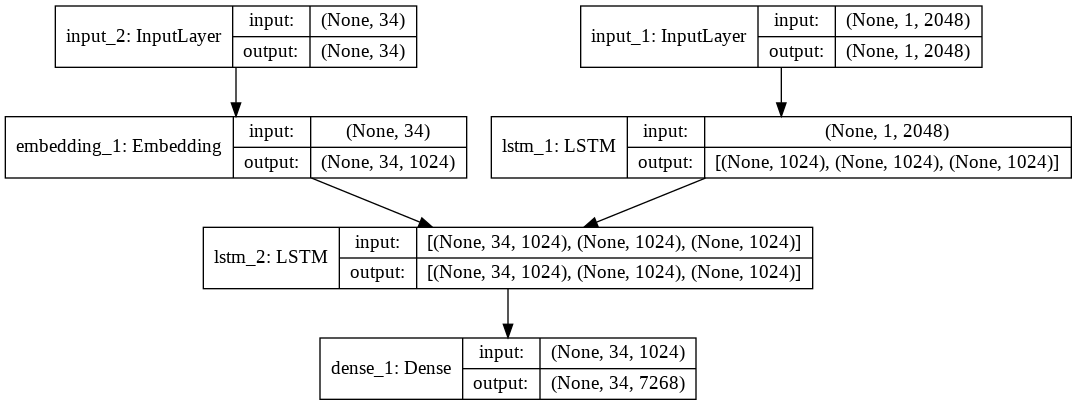

In [28]:
plot_model(image_captioning_model,show_layer_names=True,show_shapes=True)

In [29]:
image_captioning_model.compile(optimizer='rmsprop', loss=custom_loss, metrics=[acc])

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
img_cap_model = image_captioning_model.fit_generator(batch_gen, steps_per_epoch=int(np.ceil(len(train) / BATCH_SIZE)),validation_data=valid_gen,validation_steps=int(np.ceil(len(valid) / BATCH_SIZE)),callbacks=[es], epochs=EPOCHS, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
750/750 [==============================] - 254s 339ms/step - loss: 1.2192 - acc: 0.2760 - val_loss: 1.0091 - val_acc: 0.3242
Epoch 2/10
750/750 [==============================] - 253s 338ms/step - loss: 0.8607 - acc: 0.3919 - val_loss: 1.0329 - val_acc: 0.3256
Epoch 3/10
750/750 [==============================] - 253s 338ms/step - loss: 0.6561 - acc: 0.4950 - val_loss: 1.0802 - val_acc: 0.3072
Epoch 4/10
750/750 [==============================] - 254s 339ms/step - loss: 0.4656 - acc: 0.6239 - val_loss: 1.0939 - val_acc: 0.3037
Epoch 00004: early stopping


In [ ]:
image_model = Model(vis_input, lstm_img_states)

In [ ]:
encoding_test=pickle.load(open('gdrive/My Drive/Image_Captioning/encoded_images_test_inceptionV3.p', 'rb'))

In [ ]:
def load_test_description(filename,dataset):
  #sentence in target language 
  targets=dict()
 
  for line in open(filename):
    tokens=line.split()
    image_id,image_desc=tokens[0], tokens[1:]
    translation=" ".join(image_desc)
    if image_id in dataset:
      if image_id not in targets:
        targets[image_id] = list()
      targets[image_id].append(translation)

  return targets

In [ ]:
##load the Identifiers from test data file
test_file = 'gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
test= load_dataset(test_file)
print('Dataset: %d' % len(test))


##load the descriptions and test images 
test_target_texts = load_test_description('gdrive/My Drive/Image_Captioning/descriptions.txt',test)
print ("The samples in target texts is : ", len(test_target_texts))

Dataset: 1000
The samples in target texts is :  1000


In [30]:
state_input_h2 = Input(shape=(LATENT_DIM,))
state_input_c2 = Input(shape=(LATENT_DIM,))

states_inputs = [state_input_h2, state_input_c2]


text_inputs_single = Input(shape=(1,))
text_inputs_embed = embedding_layer(text_inputs_single)

text_outputs, state_h, state_c = lstm_text_cell(text_inputs_embed, initial_state=states_inputs)
text_states = [state_h, state_c]


dense_outputs = dense_layer(text_outputs)

generation_model = Model([text_inputs_single] + states_inputs, [dense_outputs] + text_states)
# decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

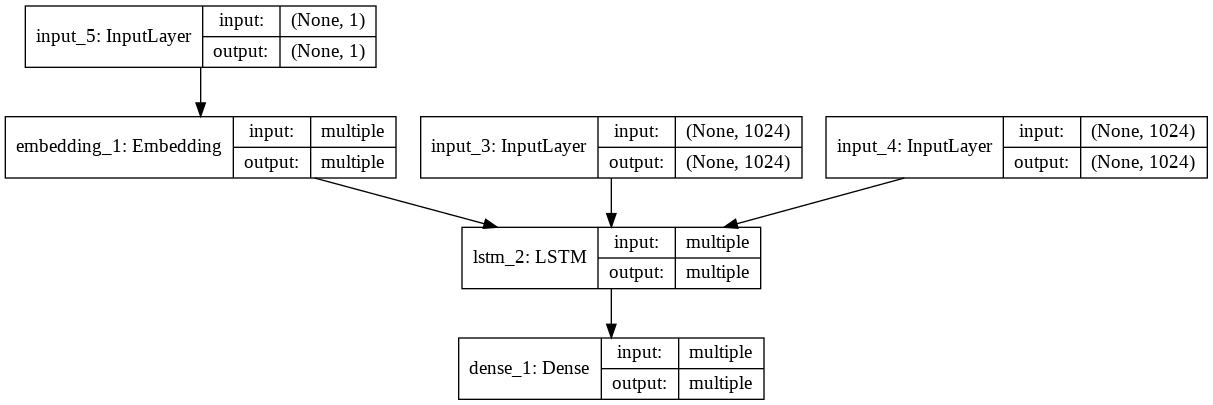

In [31]:
plot_model(generation_model,show_layer_names=True,show_shapes=True)

In [ ]:
idx2word_trans = dict(map(reversed, word2idx_outputs.items()))

In [ ]:
"""
id= 3461041826_0e24cdf597
id2=3658427967_6e2e57458d
"""

'\nid= 3461041826_0e24cdf597\nid2=3658427967_6e2e57458d\n'

In [ ]:
def generate_photo_caption(image_id):
  # test_id="3461041826_0e24cdf597.jpg"
  id_feature=np.zeros((1,1,2048))

  id_feature[0]=encoding_test.get(image_id)
  seq_index=0
  states_value=image_model.predict(id_feature[seq_index: seq_index + 1])

  # state_initial=[states_value,states_value]
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = word2idx_outputs['<sos>']
  eos = word2idx_outputs['<eos>']
  output_sentence = []

  for _ in range(max_len_target):
    output_tokens, h, c = generation_model.predict([target_seq] + states_value)
    idx = np.argmax(output_tokens[0, 0, :])
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]

  return (" ".join(output_sentence))



AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  the man with blue shirt on the beach


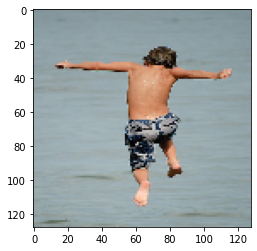

In [ ]:
test_id="3658427967_6e2e57458d.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  two dogs playing in field


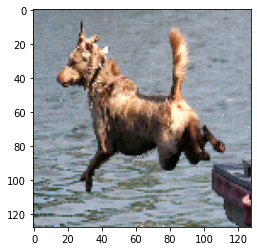

In [ ]:
test_id="493621130_152bdd4e91.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  man with sunglasses and sunglasses smiles


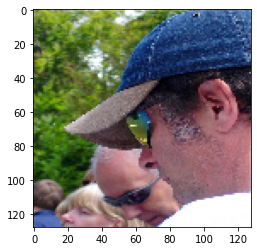

In [ ]:
test_id="754852108_72f80d421f.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  tan dog is running in the snow


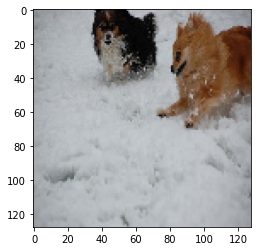

In [ ]:
test_id="2398605966_1d0c9e6a20.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  man in blue shirt looks at woman in black jacket


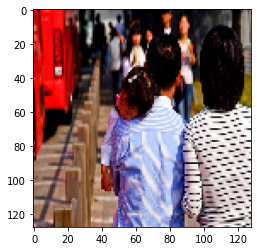

In [ ]:
test_id="2910758605_73a3f5a5c2.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  group of people paddle over their boat in the rapids


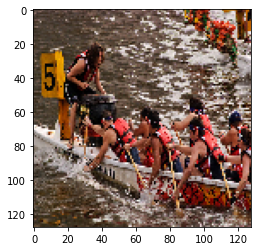

In [ ]:
test_id="3062173277_bfb5ef4c45.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  the dog jumps over the frisbee in the yard


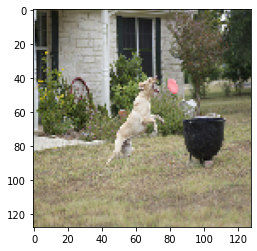

In [ ]:
test_id="2945036454_280fa5b29f.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  dog jumps over an obstacle man in grassy field


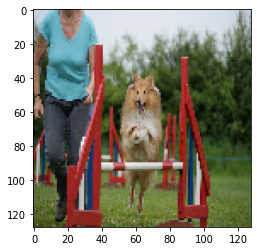

In [ ]:
test_id="2542662402_d781dd7f7c.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  man plays with tennis racket


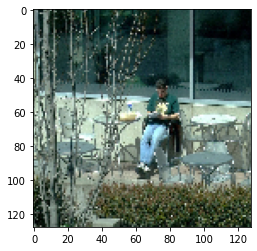

In [ ]:
test_id="2431470169_0eeba7d602.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  man is swinging on swing near some trees and river


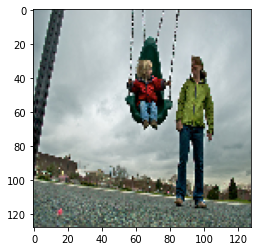

In [ ]:
test_id="3399284917_721aefe2a7.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  two men from two teams are playing basketball game


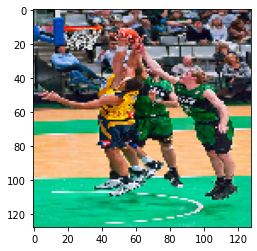

In [ ]:
test_id="2926595608_69b22be8d4.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  young girl swings high in the air above swing at park


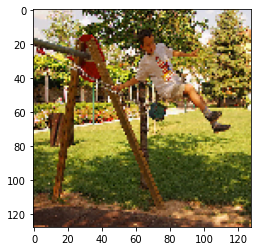

In [ ]:
test_id="497791037_93499238d8.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  person rides skateboard in midair above tall water


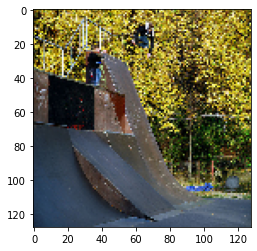

In [ ]:
test_id="2944362789_aebbc22db4.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

AxesImage(54,36;334.8x217.44)
The Caption Predicted is :  man holding harness on leash


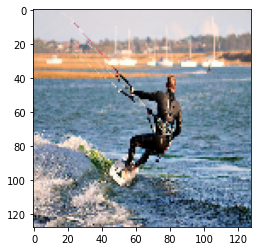

In [ ]:
test_id="2473791980_805c819bd4.jpg"
test_dir="gdrive/My Drive/Image_Captioning/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

test_img = load_img(test_dir+test_id, target_size=(128, 128))

test_img = img_to_array(test_img, data_format='channels_last')
test_img = test_img/255.
test_img=test_img.reshape(-1,128,128,3)
print(plt.imshow(test_img.reshape(128,128,3)))

print ("The Caption Predicted is : ",generate_photo_caption(test_id))

In [ ]:
def calculate_bleuscore(test_targets,dataset):


  bleu_df=pd.DataFrame(columns=['image_id','predicted_caption','bleu_1','bleu_2','bleu_3','bleu_4'])
  m=0;

  for image_id in test:
    image_id=test[m]

    ##get reference captions for the image_id
    list_of_ref=[]
    references=test_targets.get(image_id)
    for ref in references:
      list_of_ref.append(ref.split())

    #get hypothesis for image_id by predicting using our model
    pred_caption = generate_photo_caption(image_id+".jpg")
    hypothesis=pred_caption.split()
  
    result_bleu_1 = sentence_bleu(list_of_ref, hypothesis,weights=(1, 0, 0, 0),smoothing_function=SmoothingFunction().method4)
    result_bleu_2 = sentence_bleu(list_of_ref, hypothesis,weights=(0.5, 0.5, 0, 0),smoothing_function=SmoothingFunction().method4)
    result_bleu_3 = sentence_bleu(list_of_ref, hypothesis,weights=(0.33, 0.33, 0.33, 0),smoothing_function=SmoothingFunction().method4)
    result_bleu_4 = sentence_bleu(list_of_ref, hypothesis,weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=SmoothingFunction().method4)

    bleu_df.loc[m]=[image_id,pred_caption,result_bleu_1,result_bleu_2,result_bleu_3,result_bleu_4]

    m+=1

  return bleu_df


bleu_results=calculate_bleuscore(test_target_texts,test)
# print("The average bleu score of the predicted captions is :",avg_bleu)

In [34]:
bleu_results[:10]

,Unnamed: 0,image_id,predicted_caption,bleu_1,bleu_2,bleu_3,bleu_4
0,0,444481722_690d0cadcf,two young men with colorful purses stand to ea...,0.200000,0.251122,0.250743,0.232523
1,1,241345844_69e1c22464,there is college player being tackled by oklah...,0.300000,0.182574,0.203168,0.198264
2,2,2148916767_644ea6a7fa,dog is running in the snow,0.833333,0.577350,0.440423,0.346358
3,3,3197917064_e679a44b8e,two white dogs playing in the snow,0.372251,0.284311,0.221596,0.187343
4,4,3350786891_6d39b234e9,three girls and one sitting on the grass,0.500000,0.267261,0.256621,0.234048
5,5,3673165148_67f217064f,dog running on beach,0.750000,0.500000,0.358299,0.286623
6,6,2861932486_52befd8592,man with grey hair and beard wearing jacket an...,0.214286,0.272083,0.270427,0.249635
7,7,3745451546_fc8ec70cbd,two people are in the snow,0.166667,0.209688,0.212672,0.199531
8,8,3399284917_721aefe2a7,man is swinging on swing near some trees and r...,0.200000,0.149071,0.177723,0.179152
9,9,533483374_86c5d4c13e,dog is running on beach,0.800000,0.632456,0.431513,0.336534


In [35]:
print("BlEU-1 :  ",bleu_results['bleu_1'].median())
print("BlEU-2 :  ",bleu_results['bleu_2'].median())
print("BlEU-3 :  ",bleu_results['bleu_3'].median())
print("BlEU-4 :  ",bleu_results['bleu_4'].median())

BlEU-1 :   0.4
BlEU-2 :   0.2886751345948129
BlEU-3 :   0.259363562349446
BlEU-4 :   0.23567108777421486


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


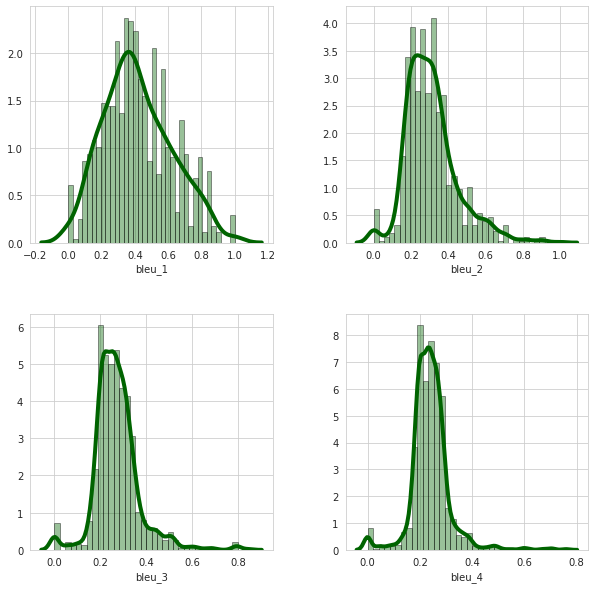

In [36]:
import seaborn as sns
sns.set_style("whitegrid")
features=bleu_results.columns[3:]
count=0
fig, axes = plt.subplots(2, 2,figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(2):
    for j in range(2):
        sns.distplot(bleu_results[features[count]], hist=True, kde=True,bins=int(180/5), color = 'darkgreen', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4},ax=axes[i, j])
        count +=1
plt.show()